In [8]:
!pip -q install nltk textblob scikit-learn pandas numpy matplotlib joblib


In [9]:
import pandas as pd
import numpy as np
import re
import nltk

nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})

print(df["label"].value_counts())
print("Missing reviews:", df["review"].isna().sum())
df[["sentiment", "label"]].head()


label
1    25000
0    25000
Name: count, dtype: int64
Missing reviews: 0


,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [12]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["review_clean"] = df["review"].apply(clean_text)
df[["review", "review_clean"]].head(2)


,review,review_clean
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...


In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def vader_scores(text):
    s = sia.polarity_scores(text)
    return pd.Series([s["compound"], s["pos"], s["neu"], s["neg"]])

df[["vader_compound","vader_pos","vader_neu","vader_neg"]] = df["review_clean"].apply(vader_scores)

df[["vader_compound","vader_pos","vader_neu","vader_neg"]].head()


,vader_compound,vader_pos,vader_neu,vader_neg
0,-0.9945,0.057,0.743,0.201
1,0.9693,0.186,0.760,0.054
2,0.9813,0.244,0.651,0.105
3,-0.8858,0.082,0.782,0.136
4,0.9803,0.162,0.786,0.052


In [14]:
from textblob import TextBlob

def textblob_scores(text):
    s = TextBlob(text).sentiment
    return pd.Series([s.polarity, s.subjectivity])

df[["tb_polarity", "tb_subjectivity"]] = df["review_clean"].apply(textblob_scores)

df[["tb_polarity", "tb_subjectivity"]].head()


,tb_polarity,tb_subjectivity
0,0.052316,0.490952
1,0.108308,0.557525
2,0.356198,0.641648
3,0.001389,0.459259
4,0.214483,0.451359


In [15]:
num_cols = [
    "vader_compound","vader_pos","vader_neu","vader_neg",
    "tb_polarity","tb_subjectivity"
]
df[num_cols].describe()


,vader_compound,vader_pos,vader_neu,vader_neg,tb_polarity,tb_subjectivity
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.312219,0.150030,0.749576,0.100397,0.100468,0.529081
std,0.803185,0.067894,0.070641,0.061196,0.160277,0.091837
min,-0.999700,0.000000,0.316000,0.000000,-1.000000,0.000000
25%,-0.664500,0.102000,0.705000,0.056000,0.002910,0.471237
50%,0.836500,0.141000,0.752000,0.093000,0.101549,0.527381
75%,0.973900,0.188000,0.798000,0.137000,0.199878,0.585238
max,0.999900,0.537000,1.000000,0.596000,1.000000,1.000000


In [16]:
from sklearn.model_selection import train_test_split

X_text = df["review_clean"].values
X_num  = df[[
    "vader_compound","vader_pos","vader_neu","vader_neg",
    "tb_polarity","tb_subjectivity"
]].values

y = df["label"].values

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42, stratify=y
)

print(len(X_text_train), len(X_text_test))


40000 10000


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_text_train)
X_test_tfidf  = tfidf.transform(X_text_test)

X_train_tfidf.shape, X_test_tfidf.shape


((40000, 30000), (10000, 30000))

In [18]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled  = scaler.transform(X_num_test)

X_train = hstack([X_train_tfidf, X_num_train_scaled])
X_test  = hstack([X_test_tfidf, X_num_test_scaled])

X_train.shape, X_test.shape


((40000, 30006), (10000, 30006))

In [24]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=15,
    random_state=42,
    verbose=True
)

mlp.fit(X_train, y_train)


Iteration 1, loss = 0.30102880
Iteration 2, loss = 0.11067480
Iteration 3, loss = 0.03976781
Iteration 4, loss = 0.01173996
Iteration 5, loss = 0.00348939
Iteration 6, loss = 0.00172014
Iteration 7, loss = 0.00135239
Iteration 8, loss = 0.00125978
Iteration 9, loss = 0.00121977
Iteration 10, loss = 0.00118943
Iteration 11, loss = 0.00116171
Iteration 12, loss = 0.00113459
Iteration 13, loss = 0.00110734
Iteration 14, loss = 0.00107965
Iteration 15, loss = 0.00105142


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=256, hidden_layer_sizes=(256, 64), max_iter=15,
              random_state=42, verbose=True)

In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

pred = mlp.predict(X_test)

acc = accuracy_score(y_test, pred)
f1  = f1_score(y_test, pred)

print("Accuracy:", acc)
print("F1 score:", f1)
print(classification_report(y_test, pred))


Accuracy: 0.9044
F1 score: 0.904476418864908
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5000
           1       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [26]:
import os, joblib

os.makedirs("models", exist_ok=True)

joblib.dump(mlp, "models/mlp_sentiment.joblib")
joblib.dump(tfidf, "models/tfidf.joblib")
joblib.dump(scaler, "models/scaler.joblib")

print("Saved: models/mlp_sentiment.joblib, models/tfidf.joblib, models/scaler.joblib")


Saved: models/mlp_sentiment.joblib, models/tfidf.joblib, models/scaler.joblib


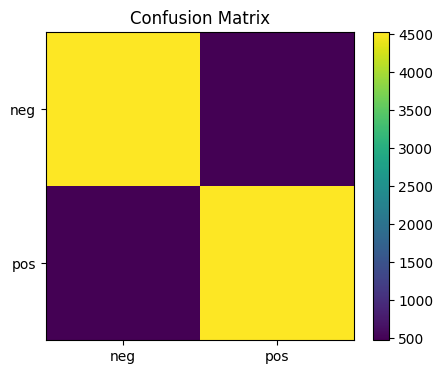

In [31]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

os.makedirs("results", exist_ok=True)

# metrics
metrics = {
    "accuracy": float(acc),
    "f1_score": float(f1),
}
with open("results/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# classification report
with open("results/classification_report.txt", "w") as f:
    f.write(classification_report(y_test, pred))

# confusion matrix image
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks([0,1], ["neg","pos"])
plt.yticks([0,1], ["neg","pos"])
plt.colorbar()


In [32]:
def predict_review(text):
    t = clean_text(text)

    # text to tfidf
    xt = tfidf.transform([t])

    # numeric feats
    v = sia.polarity_scores(t)
    tb = TextBlob(t).sentiment
    xn = np.array([[v["compound"], v["pos"], v["neu"], v["neg"], tb.polarity, tb.subjectivity]])
    xn = scaler.transform(xn)

    # combine
    x = hstack([xt, xn])
    p = mlp.predict(x)[0]
    return "positive" if p == 1 else "negative"

print(predict_review("This movie was amazing, I loved it so much!"))
print(predict_review("Boring and terrible. Waste of time."))


positive
negative


In [33]:
!zip -r imdb_submission.zip models results


  adding: models/ (stored 0%)
  adding: models/tfidf.joblib (deflated 70%)
  adding: models/scaler.joblib (deflated 24%)
  adding: models/mlp_sentiment.joblib (deflated 4%)
  adding: results/ (stored 0%)
  adding: results/metrics.json (deflated 14%)
  adding: results/classification_report.txt (deflated 66%)
